In [1]:
#Import libraries
from pyhive import presto
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import h3
from shapely.geometry import Polygon, Point
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
#Define presto credentials
presto_host = 'presto.processing.yoda.run'
presto_port = '80'
username = 'aditya.bhattar@rapido.bike'

#Create connection to presto host
connection = presto.connect(presto_host,presto_port,username = username)

In [3]:
#Query data from order_logs_snapshot

q = """
select order_id, accept_to_pickup_distance, city_name, customer_location_hex_8, customer_location_latitude, 
customer_location_longitude, hhmmss, hour, quarter_hour, service_obj_service_name, time_bucket, weekday, yyyymmdd,
order_status, cancel_reason, eta, ride_time, amount, actual_price
from orders.order_logs_snapshot
where yyyymmdd >= '20220912'
and yyyymmdd <= '20220916'
and city_name in ('Hyderabad')
and service_obj_service_name = 'Link'
"""

#Load data into pandas table
df_copy = pd.read_sql(q, connection)

In [4]:
#Create a copy of the df retrived from presto
df = df_copy.copy()

In [5]:
#View the dataset
df.head()

,order_id,accept_to_pickup_distance,city_name,customer_location_hex_8,customer_location_latitude,customer_location_longitude,hhmmss,hour,quarter_hour,service_obj_service_name,time_bucket,weekday,yyyymmdd,order_status,cancel_reason,eta,ride_time,amount,actual_price
0,6322603478606e468e201cd0,2.696,Hyderabad,8860a24a43fffff,17.418655,78.350181,044356,04,0430,Link,04:59,4,20220915,dropped,None,4.0,7.698350,33.0,33.0
1,632261ff29316e7681c68209,1.035,Hyderabad,8860a25b3bfffff,17.392141,78.469879,045135,04,0445,Link,04:59,4,20220915,customerCancelled,order cancelled before rider accepted,2.0,22.000000,93.0,NaN
2,63225a2278606e468e201ae7,0.273,Hyderabad,8860a259b9fffff,17.443089,78.390411,041802,04,0415,Link,04:00,4,20220915,dropped,None,2.0,22.416783,241.0,241.0
3,63226000853c020ac78aea46,NaN,Hyderabad,8860a258a5fffff,17.417154,78.377983,044304,04,0430,Link,04:59,4,20220915,customerCancelled,order cancelled before rider accepted,5.0,12.916667,66.0,NaN
4,6322584f78606e468e201a54,0.796,Hyderabad,8860a2593bfffff,17.443020,78.440521,041015,04,0400,Link,04:00,4,20220915,dropped,Long Pickup,5.0,14.354433,110.0,110.0


In [6]:
#Load csv file of identified hexes
df_level_1 = pd.read_csv('hyderabad_location_data_level1_demand_zone1.csv')

#Create list of hexes
level1_hexes = list(df_level_1['customer_location_hex_8'].unique())

#Filter only on the required hexes
df_filter_level1 = df[df['customer_location_hex_8'].isin(level1_hexes)]
df_filter_level1['count'] = 1

In [7]:
#Get the number of rides by order_status
ride_status = pd.pivot_table(df_filter_level1, index = ['yyyymmdd', 'hour'], columns = 'order_status', values = 'count',
 aggfunc = 'sum', fill_value=0).reset_index().rename_axis(None, axis=1)
ride_status['total'] = (ride_status['aborted'] + ride_status['customerCancelled'] + ride_status['dropped'] + ride_status['expired'] + ride_status['new'])
ride_status['G2N'] = round((ride_status['dropped']/ride_status['total'])*100, 2)
ride_status

,yyyymmdd,hour,aborted,customerCancelled,dropped,expired,new,total,G2N
0,20220912,00,0,100,142,0,0,242,58.68
1,20220912,01,1,64,86,0,0,151,56.95
2,20220912,02,0,63,66,0,0,129,51.16
3,20220912,03,0,41,27,0,0,68,39.71
4,20220912,04,0,32,41,0,0,73,56.16
...,...,...,...,...,...,...,...,...,...
115,20220916,19,1,815,1290,29,0,2135,60.42
116,20220916,20,2,435,1097,6,0,1540,71.23
117,20220916,21,2,356,859,3,0,1220,70.41
118,20220916,22,1,252,585,0,0,838,69.81


In [8]:
#Filter on dropped rides
df_dropped = df_filter_level1[df_filter_level1['order_status'] == 'dropped']

#Get the mean eta and ride_time for the dropped rides by hour
df_average = df_dropped.groupby(['yyyymmdd', 'hour'])['eta', 'ride_time', 'accept_to_pickup_distance'].mean().reset_index()

#Get the number of rides done per hour
df_dropped['count'] = 1
df_rides = df_dropped.groupby(['yyyymmdd', 'hour'])['count'].sum().reset_index()

#Merge df_average and df_rides
df_average = df_average.merge(df_rides, on = ['yyyymmdd', 'hour'], how = 'left')
df_average = df_average.merge(ride_status[['yyyymmdd', 'hour', 'total', 'G2N']], on = ['yyyymmdd', 'hour'], how = 'left')
df_average

,yyyymmdd,hour,eta,ride_time,accept_to_pickup_distance,count,total,G2N
0,20220912,00,4.330986,10.797898,1.235310,142,242,58.68
1,20220912,01,4.313953,10.851872,1.008116,86,151,56.95
2,20220912,02,4.303030,8.760330,1.152424,66,129,51.16
3,20220912,03,4.555556,12.209731,1.348074,27,68,39.71
4,20220912,04,4.439024,9.137421,1.481829,41,73,56.16
...,...,...,...,...,...,...,...,...
115,20220916,19,3.621705,17.479256,0.988090,1290,2135,60.42
116,20220916,20,3.211486,13.702997,0.688046,1097,1540,71.23
117,20220916,21,3.186263,12.132756,0.627508,859,1220,70.41
118,20220916,22,3.350427,11.640288,0.703460,585,838,69.81


In [9]:
#Assume 10% reduction in eta if batching is implemented
df_average2 = df_average.copy()
df_average['adjusted_eta_10%'] = round(df_average['eta'].apply(lambda x: x - 0.1*x), 2)
df_average2['adjusted_eta_20%'] = round(df_average2['eta'].apply(lambda x: x - 0.2*x), 2)

#Total ETA before and after reduction
df_average['total_eta'] = round(df_average['eta']*df_average['count'], 2)
df_average2['total_eta'] = round(df_average2['eta']*df_average2['count'], 2)
df_average['total_adjusted_eta_10%'] = round(df_average['adjusted_eta_10%']*df_average['count'], 2)
df_average2['total_adjusted_eta_20%'] = round(df_average2['adjusted_eta_20%']*df_average2['count'], 2)

#Get the total eta saved
df_average['eta_saved_10%'] = round(df_average['total_eta'] - df_average['total_adjusted_eta_10%'], 2)
df_average2['eta_saved_20%'] = round(df_average2['total_eta'] - df_average2['total_adjusted_eta_20%'], 2)

#Additional number of rides possible due to improved eta
df_average['additional_rides_10%'] = round(df_average['eta_saved_10%']/df_average['ride_time'], 2)
df_average2['additional_rides_20%'] = round(df_average2['eta_saved_20%']/df_average['ride_time'], 2)

#Additional G2N
df_average['additional_G2N_10%'] = round((df_average['additional_rides_10%']/df_average['total']*100), 2)
df_average2['additional_G2N_20%'] = round((df_average2['additional_rides_20%']/df_average2['total']*100), 2)
df_average = df_average.rename(columns = {'count':'dropped_rides'})
df_average2 = df_average2.rename(columns = {'count':'dropped_rides'})
df_average['rides_per_20_sec'] = round(df_average['total']/180, 2)
df_average2['rides_per_20_sec'] = round(df_average['total']/180, 2)
df_average

,yyyymmdd,hour,eta,ride_time,accept_to_pickup_distance,dropped_rides,total,G2N,adjusted_eta_10%,total_eta,total_adjusted_eta_10%,eta_saved_10%,additional_rides_10%,additional_G2N_10%,rides_per_20_sec
0,20220912,00,4.330986,10.797898,1.235310,142,242,58.68,3.90,615.0,553.80,61.20,5.67,2.34,1.34
1,20220912,01,4.313953,10.851872,1.008116,86,151,56.95,3.88,371.0,333.68,37.32,3.44,2.28,0.84
2,20220912,02,4.303030,8.760330,1.152424,66,129,51.16,3.87,284.0,255.42,28.58,3.26,2.53,0.72
3,20220912,03,4.555556,12.209731,1.348074,27,68,39.71,4.10,123.0,110.70,12.30,1.01,1.49,0.38
4,20220912,04,4.439024,9.137421,1.481829,41,73,56.16,4.00,182.0,164.00,18.00,1.97,2.70,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20220916,19,3.621705,17.479256,0.988090,1290,2135,60.42,3.26,4672.0,4205.40,466.60,26.69,1.25,11.86
116,20220916,20,3.211486,13.702997,0.688046,1097,1540,71.23,2.89,3523.0,3170.33,352.67,25.74,1.67,8.56
117,20220916,21,3.186263,12.132756,0.627508,859,1220,70.41,2.87,2737.0,2465.33,271.67,22.39,1.84,6.78
118,20220916,22,3.350427,11.640288,0.703460,585,838,69.81,3.02,1960.0,1766.70,193.30,16.61,1.98,4.66


In [10]:
df_average2

,yyyymmdd,hour,eta,ride_time,accept_to_pickup_distance,dropped_rides,total,G2N,adjusted_eta_20%,total_eta,total_adjusted_eta_20%,eta_saved_20%,additional_rides_20%,additional_G2N_20%,rides_per_20_sec
0,20220912,00,4.330986,10.797898,1.235310,142,242,58.68,3.46,615.0,491.32,123.68,11.45,4.73,1.34
1,20220912,01,4.313953,10.851872,1.008116,86,151,56.95,3.45,371.0,296.70,74.30,6.85,4.54,0.84
2,20220912,02,4.303030,8.760330,1.152424,66,129,51.16,3.44,284.0,227.04,56.96,6.50,5.04,0.72
3,20220912,03,4.555556,12.209731,1.348074,27,68,39.71,3.64,123.0,98.28,24.72,2.02,2.97,0.38
4,20220912,04,4.439024,9.137421,1.481829,41,73,56.16,3.55,182.0,145.55,36.45,3.99,5.47,0.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,20220916,19,3.621705,17.479256,0.988090,1290,2135,60.42,2.90,4672.0,3741.00,931.00,53.26,2.49,11.86
116,20220916,20,3.211486,13.702997,0.688046,1097,1540,71.23,2.57,3523.0,2819.29,703.71,51.35,3.33,8.56
117,20220916,21,3.186263,12.132756,0.627508,859,1220,70.41,2.55,2737.0,2190.45,546.55,45.05,3.69,6.78
118,20220916,22,3.350427,11.640288,0.703460,585,838,69.81,2.68,1960.0,1567.80,392.20,33.69,4.02,4.66


<AxesSubplot:xlabel='accept_to_pickup_distance', ylabel='G2N'>

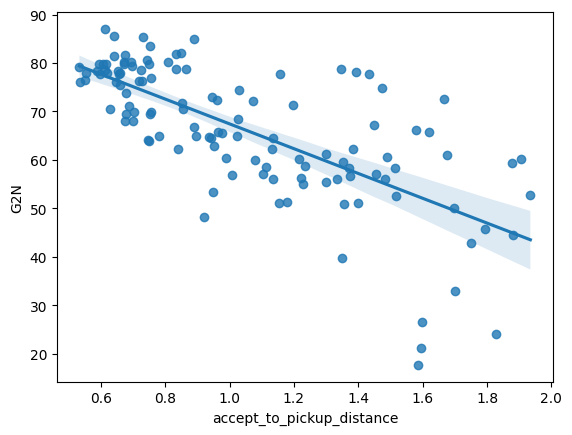

In [11]:
sns.regplot(x = df_average['accept_to_pickup_distance'], y = df_average['G2N'])

In [12]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [13]:
X = df_average[['accept_to_pickup_distance']]
y = df_average[['G2N']]
lr = Ridge(alpha = 2)
lr.fit(X, y)

Ridge(alpha=2)

In [14]:
print(f"slope: {lr.coef_}")

slope: [[-22.98324046]]


In [15]:
print(f"slope: {lr.intercept_}")

slope: [90.30404358]


In [16]:
lr.score(X, y)

0.49645531501764983

In [17]:
df_average[df_average['hour'] == '09']

,yyyymmdd,hour,eta,ride_time,accept_to_pickup_distance,dropped_rides,total,G2N,adjusted_eta_10%,total_eta,total_adjusted_eta_10%,eta_saved_10%,additional_rides_10%,additional_G2N_10%,rides_per_20_sec
9,20220912,09,5.119389,11.389345,1.827346,1047,4350,24.07,4.61,5360.0,4826.67,533.33,46.83,1.08,24.17
33,20220913,09,5.221175,11.749101,1.880586,1379,3100,44.48,4.70,7200.0,6481.30,718.70,61.17,1.97,17.22
57,20220914,09,5.317333,12.640661,1.904273,1500,2496,60.10,4.79,7976.0,7185.00,791.00,62.58,2.51,13.87
81,20220915,09,5.164005,12.469268,1.878475,1628,2739,59.44,4.65,8407.0,7570.20,836.80,67.11,2.45,15.22
105,20220916,09,4.820866,11.034253,1.665401,1524,2099,72.61,4.34,7347.0,6614.16,732.84,66.42,3.16,11.66


In [18]:
df_average[df_average['hour'] == '10']

,yyyymmdd,hour,eta,ride_time,accept_to_pickup_distance,dropped_rides,total,G2N,adjusted_eta_10%,total_eta,total_adjusted_eta_10%,eta_saved_10%,additional_rides_10%,additional_G2N_10%,rides_per_20_sec
10,20220912,10,5.066038,12.476052,1.751651,1272,2974,42.77,4.56,6444.0,5800.32,643.68,51.59,1.73,16.52
34,20220913,10,4.819141,13.283305,1.675586,1421,2326,61.09,4.34,6848.0,6167.14,680.86,51.26,2.20,12.92
58,20220914,10,4.642214,12.429293,1.449763,1554,2311,67.24,4.18,7214.0,6495.72,718.28,57.79,2.50,12.84
82,20220915,10,4.094737,11.810356,1.157771,1520,1955,77.75,3.69,6224.0,5608.80,615.20,52.09,2.66,10.86
106,20220916,10,3.650412,10.702941,0.833540,1456,1778,81.89,3.29,5315.0,4790.24,524.76,49.03,2.76,9.88
